In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Step 1: Dataset Preparation
data_dir = "/kaggle/input/cotton-leaf-disease-dataset/cotton"
batch_size = 32
img_size = (224, 224)

In [3]:
# Augmenting data for robustness
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

In [4]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset="training",
    class_mode="categorical"
)


Found 1369 images belonging to 4 classes.


In [5]:
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset="validation",
    class_mode="categorical"
)

Found 340 images belonging to 4 classes.


In [6]:
# Step 2: Load Pre-trained ResNet101V2
base_model = ResNet101V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

In [7]:
# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
output = Dense(len(train_gen.class_indices), activation="softmax")(x)  # Output layer for classes

model = Model(inputs=base_model.input, outputs=output)

In [8]:
# Step 3: Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
# Step 4: Train the Model
callbacks = [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 55s 814ms/step - accuracy: 0.3982 - loss: 1.3546 - val_accuracy: 0.8294 - val_loss: 0.6681
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 462ms/step - accuracy: 0.8017 - loss: 0.6693 - val_accuracy: 0.9088 - val_loss: 0.4408
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - accuracy: 0.8829 - loss: 0.4286 - val_accuracy: 0.8941 - val_loss: 0.4072
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - accuracy: 0.9077 - loss: 0.3285 - val_accuracy: 0.9118 - val_loss: 0.3750
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.9426 - loss: 0.2587 - val_accuracy: 0.9353 - val_loss: 0.2927
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.9489 - loss: 0.2204 - val_accuracy: 0.9265 - val_loss: 0.2972
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - accuracy: 0.9559 - loss: 0.1868 - val_accuracy: 0.9265 - val_loss: 0.2547
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - accuracy: 0.9622 - loss: 0.1523 - val_accuracy: 0.914

In [10]:
# Save the Model
model.save("cotton_disease_resnet101v2.h5")

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [17]:
def generate_grad_cam(model, img_path, last_conv_layer_name, class_index):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))  # Adjust size as needed
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Create a Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,  # Convolutional layer output
            model.output  # Model predictions
        ]
    )

    # Ensure class_index is an integer
    class_index = int(class_index)  # Convert NumPy array or Tensor to scalar integer

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # Convert predictions to tensor if needed
        predictions = tf.convert_to_tensor(predictions)
        loss = predictions[:, class_index]  # Class-specific loss

    # Compute gradients of the loss w.r.t. the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)

    # Compute the mean intensity of the gradients across the feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by the pooled gradients
    conv_outputs = conv_outputs[0]  # Remove the batch dimension
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap to [0, 1] for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()



In [18]:
def overlay_heatmap(img_path, heatmap):
    import cv2
    import numpy as np

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return superimposed_img


In [20]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Load the image
img_path = "/kaggle/input/image-data/cotton disease image.jpeg"
img = load_img(img_path, target_size=(224, 224))  # Resize to the input size expected by the model

# Convert the image to a numpy array
img_array = img_to_array(img)

# Preprocess the image (e.g., scaling pixel values)
img_array = img_array / 255.0  # Scale pixel values to [0, 1] range
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

# Predict the class
class_index = np.argmax(model.predict(img_array), axis=-1)

# Generate Grad-CAM heatmap (assuming you have a function named `generate_grad_cam`)
heatmap = generate_grad_cam(model, img_path, "conv5_block3_out", class_index)

# Overlay the heatmap (assuming you have a function named `overlay_heatmap`)
result = overlay_heatmap(img_path, heatmap)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-17-63eea5eca530>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index = int(class_index)  # Convert NumPy array or Tensor to scalar integer
<ipython-input-18-0fdce76519fe>:7: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


In [21]:
# Predict the class
class_index = np.argmax(model.predict(img_array), axis=-1)

# Ensure class_index is a scalar value before passing it to generate_grad_cam
class_index = int(class_index.item())  # or class_index[0] if it's a 1D array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


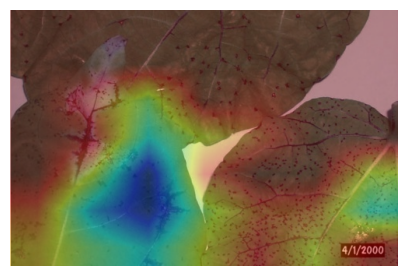

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Load the image
img_path = "/kaggle/input/cotton-leaf-disease-dataset/cotton/bacterial_blight/bact1.jpg"
img = load_img(img_path, target_size=(224, 224))  # Resize to the input size expected by the model

# Convert the image to a numpy array
img_array = img_to_array(img)

# Preprocess the image (e.g., scaling pixel values)
img_array = img_array / 255.0  # Scale pixel values to [0, 1] range
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

# Predict the class
class_index = np.argmax(model.predict(img_array), axis=-1)

# Ensure class_index is a scalar value
class_index = int(class_index.item())  # or class_index[0] if it's a 1D array

# Generate Grad-CAM heatmap (assuming you have a function named `generate_grad_cam`)
heatmap = generate_grad_cam(model, img_path, "conv5_block3_out", class_index)

# Overlay the heatmap (assuming you have a function named `overlay_heatmap`)
result = overlay_heatmap(img_path, heatmap)

# Visualize the result
plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.axis('off')  # Hide axes
plt.show()
